In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from supplemental_code.supplemental_code import save_obj, detect_landmark, render
import math
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

In [2]:
# load model (cropped only to face)
bfm = h5py.File("model2017-1_face12_nomouth.h5",'r')

# (85764,) --> shape of mean
mean_shape = np.asarray(bfm['shape/model/mean'], dtype=np.float32)
# (199,) --> shape of var
var_shape = np.asarray(bfm['shape/model/pcaVariance'], dtype=np.float32)
# (85764, 199) --> 199 principal components
PC_shape = np.asarray(bfm['shape/model/pcaBasis'], dtype=np.float32)

# (85764, ) --> shape of mean
mean_expression = np.asarray(bfm['expression/model/mean'], dtype=np.float32)
# (100,) --> shape of var
var_expression = np.asarray(bfm['expression/model/pcaVariance'], dtype=np.float32)
# (85764, 100) --> 100 principal components
PC_expression = np.asarray(bfm['expression/model/pcaBasis'], dtype=np.float32)

# (85764, ) --> shape of mean
mean_color = np.asarray(bfm['color/model/mean'], dtype=np.float32)
# (100,) --> shape of var
var_color = np.asarray(bfm['color/model/pcaVariance'], dtype=np.float32)
# (85764, 100) --> 100 principal components
PC_color = np.asarray(bfm['color/model/pcaBasis'], dtype=np.float32)

triangles = np.asarray(bfm['shape/representer/cells'], dtype=np.float32)

## 4.2.1

In [3]:
def construct_3d_face(mean_shape, var_shape, PC_shape,
                mean_expression, var_expression, PC_expression,
                mean_color, var_color, PC_color,
                s1, s2):

    obj1 = mean_shape.reshape(-1,3) + np.dot(PC_shape,(s1* np.sqrt(var_shape))).reshape(-1,3)
    obj2 = mean_expression.reshape(-1,3) + np.dot(PC_expression,(s2* np.sqrt(var_expression))).reshape(-1,3)
    color = mean_color.reshape(-1,3) #+ np.dot(PC_color,(s3* var_color)).reshape(-1,3)

    obj = obj1 + obj2 + color # obj shape = (28588, 3)
    
    return obj

In [5]:
for i in range(5):
    s1 = np.random.uniform(-1,1,var_shape.shape[0])
    s2 = np.random.uniform(-1,1,var_expression.shape[0])
    obj = construct_3d_face(mean_shape, var_shape, PC_shape,
                mean_expression, var_expression, PC_expression,
                mean_color, var_color, PC_color,
                s1, s2)
    color = mean_color.reshape(-1,3)
    save_obj(f'PCA_{i}.obj', obj, color, triangles.T)

## 4.2.2

In [6]:
s1 = np.random.uniform(-1,1,var_shape.shape[0])
s2 = np.random.uniform(-1,1,var_expression.shape[0])
obj = construct_3d_face(mean_shape, var_shape, PC_shape,
                mean_expression, var_expression, PC_expression,
                mean_color, var_color, PC_color,
                s1, s2)
color = mean_color.reshape(-1,3)

In [9]:
save_obj(f'PCA_inp.obj', obj, color, triangles.T)

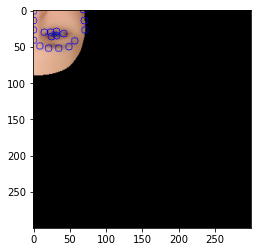

In [65]:
landmark_out = obj[landmark_indices.astype('int')]
image = render(obj[:,:3], color, triangles.T.astype('int'), H=H, W=W)
image = np.array(image*255).astype('uint8')
for landmark in landmark_out[:,:2].astype('int'):
    image = cv2.circle(image, landmark, radius=5, color=(0, 0, 255), thickness=1)
plt.imshow(image)

In [7]:
omega=math.radians(10)
R_y = np.array([[np.cos(omega), 0, np.sin(omega)], [0, 1, 0],
                     [-np.sin(omega), 0, np.cos(omega)]])
transformed = obj@R_y
save_obj(f'PCA_10deg.obj', transformed, color, triangles.T)

In [8]:
omega=math.radians(-10)
R_y = np.array([[np.cos(omega), 0, np.sin(omega)], [0, 1, 0],
                     [-np.sin(omega), 0, np.cos(omega)]])
transformed = obj@R_y
save_obj(f'PCA_m10deg.obj', transformed, color, triangles.T)

In [73]:
import math 

def get_projection(obj, omega=math.radians(10), t=[0,0,-500], minn=None, maxx=None):

    # rotate around y so second row is [0,1,0]
    R_y = np.array([[np.cos(omega), 0, np.sin(omega)], [0, 1, 0],
                     [-np.sin(omega), 0, np.cos(omega)]])

    # transform with equation given in assignment
    transformed = np.dot(obj, R_y) + np.array(t)

    # get box around object
    if type(minn) == type(None):
        minn = np.min(transformed, axis=0)
    if type(maxx) == type(None):
        maxx = np.max(transformed, axis=0)

    x1 = minn[0]
    x2 = maxx[0]

    y1 = minn[1]
    y2 = maxx[1]

    height = y2 - y1
    width = x2 - x1
    aspect_ratio = width/height
    f = 500
    n = 0.1
    FOV = 120
    t = math.tan(FOV/2)*n
    b = -t*aspect_ratio
    r = t*aspect_ratio
    l = -t*aspect_ratio

    #The viewport is defined as the rectangle between (vl,vb) and (vr,vt)
    V = np.array([[x1/2, 0,0, x2/2],[0, y1/2, 0, y2/2],[0,0, 1/2, 1/2],[0,0,0,1]])

    P = np.zeros(shape=(4,4))
    P[0][0] = 2*n/(r-l)
    P[1][1] = 2*n/(t-b)
    P[2][2] = -(f+n)/(f-n)
    P[3][3] = 0
    P[0][2] = (r+l)/(r-l)
    P[1][2] = (t+b)/(t-b)
    P[3][2] = -1
    P[2][3] = -(2*f*n)/(f-n)

    new = np.ones(shape=(transformed.shape[0], transformed.shape[1]+1))
    new[:,:3] = transformed

    total = new@((V.T*P).T)

    total[:,0] = total[:,0]/ total[:,3]
    total[:,1] = total[:,1]/ total[:,3]
    total[:,2] = total[:,2]/ total[:,3]
    
    return total, minn, maxx

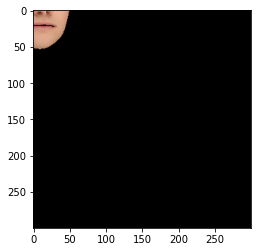

In [74]:
H=300
W=300
out, minn, maxx = get_projection(obj)
image = render(out[:,:3], color, triangles.T.astype('int'), H=H, W=W)
img = np.array(image*255).astype('uint8')
plt.imshow(img)

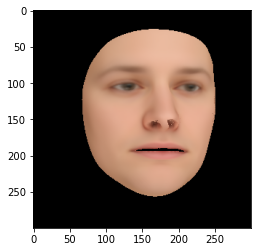

In [75]:
trans_out = out*2 + [H/2,W/2,0,0]   
image = render(trans_out[:,:3], color, triangles.T.astype('int'), H=H, W=W)
img = np.array(image*255).astype('uint8')
plt.imshow(img)

Getting landmarks using the given file:

In [78]:
landmark_indices = np.loadtxt("supplemental_code/Landmarks68_model2017-1_face12_nomouth.anl")
landmark_out, _, _ = get_projection(obj[landmark_indices.astype('int')], minn=minn, maxx=maxx)
landmark_out = landmark_out*2 + [H/2,W/2,0,0] 

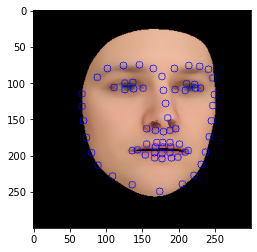

In [80]:
image = np.copy(img)
for landmark in landmark_out[:,:2].astype('int'):
    image = cv2.circle(image, landmark, radius=5, color=(0, 0, 255), thickness=1)
  
plt.imshow(image)

Getting landmarks using given detect function:

In [81]:
detected_landmarks = detect_landmark(img)

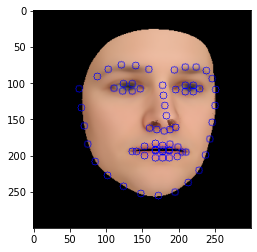

In [83]:
image = np.copy(img)
for landmark in landmarks:
    image = cv2.circle(image, landmark, radius=5, color=(0, 0, 255), thickness=1)
  
plt.imshow(image)